### Notebook that plots the three examples of how the method extracts the change of stability from the RPPA vs. RNA regression. It displays the regression of three examples alongside the distribution of RPPA, mRNA and Stability Change. 
- Figure 3a shows the regression+boxplots of CCNE1 in UCEC and the residuals are displayed. 
- Figure 3b shows the regression+boxplots of TP53 in COADREAD. 
- Figure 3c shows the regression+boxplots of CHEK2 in UCEC. 

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import gridspec
from scipy import stats

### paths

In [2]:
base="../../" 
path_output_missense_degron_rppa = os.path.join(base,"data","missense_clean_type_rppa.tsv.gz")
dataset_rppa_irls = os.path.join(base,"data/rppa_matched_irls.tsv.gz")
output_path_plots = os.path.join(base,"plots/Figure2/")

### Load rppa data

In [3]:
df_rppa = pd.read_csv(dataset_rppa_irls,sep="\t",compression="gzip")

In [4]:
def set_altered(row):
    snv = ["Missense_Mutation","In_Frame_Indel","In_Frame_Ins"]
    if row["Phenotype"] in snv:
        return "SNV"
    elif row["Phenotype"] == "WT":
        return "WT"
    else:
        return "Other"
        
df_rppa["Altered?"] = df_rppa.apply(lambda row: set_altered(row),axis=1)

### Auxiliary functions

In [5]:
def get_coordinates_text(query_data_mt):
    x = []
    y = []
    text = []
    for index,row in query_data_mt.iterrows():
        x.append((row["log2(RSEM)"],row["log2(RSEM)"]))
        y.append((row["RPPA_VALUES"],row["Y"]))
        text.append("{0:.2f}".format(row["Raw_Residual"]))
    return x,y,text
def get_coordinates(query_data_mt):
    x = []
    y = []
    for index,row in query_data_mt.iterrows():
        x.append((row["log2(RSEM)"],row["log2(RSEM)"]))
        y.append((row["RPPA_VALUES"],row["Y"]))
    return x,y
def get_data(protein,cancer):
    query_data=df_rppa[(df_rppa["Cancer_Type"]==cancer)&(df_rppa["Protein"]==protein)&((df_rppa["Altered?"]=="WT")|((df_rppa["Altered?"]=="SNV")))&(df_rppa["CNA"]<2)&(~df_rppa["Altered_E3_Ligases"])]
    query_data_wt=df_rppa[(df_rppa["Cancer_Type"]==cancer)&(df_rppa["Protein"]==protein)&((df_rppa["Altered?"]=="WT"))&(df_rppa["CNA"]<2)&(~df_rppa["Altered_E3_Ligases"])]
    query_data_mt=df_rppa[(df_rppa["Cancer_Type"]==cancer)&(df_rppa["Protein"]==protein)&((df_rppa["Altered?"]=="SNV"))&(df_rppa["CNA"]<2)&(~df_rppa["Altered_E3_Ligases"])]
    return query_data,query_data_wt,query_data_mt


### Functions to generate the two plots

In [6]:
def plot_regression(query_data,query_data_wt,query_data_mt,name):
    fig,ax = plt.subplots(figsize=(3,3))
    query_data_wt["Y"] = query_data.apply(lambda row: row["RPPA_VALUES"]-row["Raw_Residual"],axis=1)
    query_data_mt["Y"] = query_data.apply(lambda row: row["RPPA_VALUES"]-row["Raw_Residual"],axis=1)
    sns.regplot(x="log2(RSEM)", y="RPPA_VALUES", data=query_data_wt,robust=True,ax=ax,label="WT",color="#4682B4",line_kws={'linewidth':0.5},scatter_kws={'alpha':0.8,'s':5,'linewidth':0})
    sns.regplot(x="log2(RSEM)", y="RPPA_VALUES", data=query_data_mt,fit_reg=False,scatter_kws={'alpha':1.0,'s':5,'linewidth':0},color="#cc0000",ax=ax,label="SNP (Missense_Variant or In_Frame del/ins)")
    x,y,text = get_coordinates_text(query_data_mt)
    for i in range(0,len(x)):
        plt.plot(x[i], y[i], '--', color='#cc0000',linewidth=.5)
        pass
        #plt.annotate(xy=(x[i][0], y[i][0]),xytext=(x[i][0]+0.01, (y[i][0]+y[i][1])/2),s=text[i],color="#cc0000") # Annotate the distance
    x,y,text = get_coordinates_text(query_data_wt.sort_values("log2(RSEM)",ascending=False))
    for i in range(0,len(x)):
        plt.plot(x[i], y[i], '--', color='#4682B4',alpha=0.3,linewidth=0.5)
        pass
        if i<10:
            #plt.annotate(xy=(x[i][0], y[i][0]),xytext=(x[i][0]+0.01, (y[i][0]+y[i][1])/2),s=text[i],color="#4682B4")
            pass

    ax.tick_params(axis = 'both', which = 'major', labelsize =6,pad=1)
    ax.set_xlabel("log2(RSEM)",fontsize=8)
    ax.set_ylabel("RPPA",fontsize=8)
    #ax.legend(fontsize="large")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(name,fontsize=14)
    plt.savefig(output_path_plots+'/Figure_Regression_'+name+'.pdf')

def plot_boxplots(query_data,query_data_wt,query_data_mt,name):
    
    fig,ax = plt.subplots(nrows=1,ncols=3)
    fig.set_size_inches(3, 1.5)
    gs = gridspec.GridSpec(1, 3,width_ratios=[1,1,1])
    gs.update(wspace=0.15, hspace=0.0)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])
    s = ["SNV","WT"]
    p = {"SNV":"#ff3333","WT":"#4682B4"}
    g = sns.stripplot(x="Altered?",y="log2(RSEM)",data=query_data_mt,jitter=True,alpha=0.6,size=2,order=s,palette=p,ax=ax0)
    g = sns.boxplot(x="Altered?",y="log2(RSEM)",data=query_data,width=0.4,saturation=0.7,order=s,palette=p,fliersize=0.,ax=ax0, linewidth=0.5)

    g = sns.stripplot(x="Altered?",y="RPPA_VALUES",data=query_data_mt,jitter=True,alpha=0.6,size=2,order=s,palette=p,ax=ax1)
    g = sns.boxplot(x="Altered?",y="RPPA_VALUES",data=query_data,width=0.4,saturation=0.7,order=s,palette=p,fliersize=0.,ax=ax1,linewidth=0.5)

    g = sns.stripplot(x="Altered?",y="Stability_Change",data=query_data_mt,jitter=True,alpha=0.6,size=2,order=s,palette=p,ax=ax2)
    g = sns.boxplot(x="Altered?",y="Stability_Change",data=query_data,width=0.4,saturation=0.7,order=s,palette=p,fliersize=0.,ax=ax2,linewidth=0.5)

    
    # Plot significance 
    sample_size = int(query_data_mt.shape[0])
    # Calculate significance
    pvalue = stats.mannwhitneyu(query_data_mt["Stability_Change"].values,query_data_wt["Stability_Change"].values)[1]
    # Draw a line
    maxv = np.nanmax(query_data["Stability_Change"].values)
    ax2.axhline(y=maxv+0.8,xmin=0.25,xmax=0.75,color="black",linewidth=0.25)
    if pvalue < 1.05:
        ax2.text(y=maxv+1.,x=0.25,s="P="+str("{0:.2E}".format(pvalue)),fontsize=6)
    else:
        ax2.text(y=maxv+1.,x=0.25,s="P=n.s.",fontsize=6)
    ax2.text(y=np.nanmax(query_data_mt["Stability_Change"].values)+0.4,x=-0.15,s="N="+str(sample_size),fontsize=6)
    ax2.set_ylim((ax2.get_ylim()[0],maxv+1.6,))
    
    # Tune the axis
    
    ax0.set_ylabel("")
    ax0.set_xlabel("mRNA expression \n (logRPKM)",fontsize=6)
    ax0.set_xticks([])
    
    ax1.set_ylabel("")
    ax1.set_xlabel("Protein expression \n(RPPA)",fontsize=6)
    ax1.set_xticks([])
    
    ax2.set_ylabel("")
    ax2.set_xlabel("Stability Change",fontsize=6)
    ax2.set_xticks([])
    
    ax0.tick_params(axis = 'both', which = 'both', labelsize =4,left="off"  , pad=0.25 ,width=0.25)
    ax0.spines['right'].set_visible(False)
    ax0.spines['top'].set_visible(False)
    ax1.tick_params(axis = 'both', which = 'both', labelsize =4, left="off",  pad=0.25 ,width=0.25)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax2.tick_params(axis = 'both', which = 'both', labelsize =4 , left="off", pad=0.25 ,width=0.25)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    plt.savefig(output_path_plots+'/Figure_Boxplot'+name+'.pdf')
    return None
    
   
    
    
    
    
    

### CCNE1-UCEC

In [8]:
df_rppa[(df_rppa["Hugo_Symbol"]=="CCNE1")&(df_rppa["Cancer_Type"]=="UCEC")&(df_rppa["Phenotype"]=="Missense_Mutation")&(~df_rppa["Altered_E3_Ligases"])]

Hugo_Symbol Matchable_Sample_ID Cancer_Type         RSEM  log2(RSEM)  \
268151       CCNE1        TCGA-AJ-A2QM        UCEC  1283.480000   10.325845   
268156       CCNE1        TCGA-AJ-A3EK        UCEC   198.287000    7.631447   
268571       CCNE1        TCGA-B5-A1MX        UCEC   450.475773    8.815306   
268577       CCNE1        TCGA-B5-A3FC        UCEC   543.911000    9.087227   
270228       CCNE1        TCGA-DF-A2KN        UCEC  1072.550000   10.066829   
271202       CCNE1        TCGA-EO-A3AU        UCEC   199.909000    7.643200   
271203       CCNE1        TCGA-EO-A3AV        UCEC   327.191000    8.353990   

         Protein  RPPA_VALUES  CNA         CCDS          Phenotype  ...  \
268151  CYCLINE1     1.772000    0  CCDS12419.1  Missense_Mutation  ...   
268156  CYCLINE1    -0.043601    0  CCDS12419.1  Missense_Mutation  ...   
268571  CYCLINE1     0.419360    0  CCDS12419.1  Missense_Mutation  ...   
268577  CYCLINE1     0.443780    0  CCDS12419.1  Missense_Mutation  ...   
270228  CYCLINE1     0.148690    0  CCDS12419.1  Missense_Mutation  ...   
271202  CYCLINE1    -0.285230    0  CCDS12419.1  Missense_Mutation  ...   
271203  CYCLINE1     0.192600    0  CCDS12419.1  Missense_Mutation  ...   

       Variant_Type                                                VAF  \
268151          SNP                                 0.2571428571428571   
268156      SNP,SNP             0.3333333333333333,0.13043478260869565   
268571          SNP                                 0.3333333333333333   
268577  SNP,SNP,SNP  0.3146551724137931,0.373015873015873,0.4285714...   
270228      SNP,SNP                           0.21468926553672316,0.38   
271202          SNP                                 0.3333333333333333   
271203          SNP                                               0.15   

                                    Ubiquitinases_Mutated Altered_E3_Ligases  \
268151  BIRC6,BRCA1,CCDC36,DZIP3,HECW2,HERC6,NEDD4,NFX...              False   
268156  ANAPC16,ANAPC4,ANKIB1,APC,ARIH2,ASB12,ASB2,ASB...              False   
268571  AMFR,APC,ARIH2,ASB1,BAP1,BFAR,BIRC6,CBL,CCDC36...              False   
268577  ANAPC11,ANAPC5,APC,AREL1,ARIH1,ASB1,ASB15,ASB1...              False   
270228  ANAPC5,ASB12,ASB15,ASB3,BIRC6,BTBD1,CDC27,CHFR...              False   
271202  APC,BFAR,CGRRF1,FBXL3,HECTD3,KLHL12,KLHL13,MGR...              False   
271203  APC,ASB12,ASB5,BAP1,BARD1,BRAP,CBLB,CCNB1IP1,C...              False   

       Epitope Disrupt_Epitope  Raw_Residual Stability_Change  \
268151       0           False      0.547957         1.000668   
268156       0           False     -0.135032        -0.246593   
268571       0           False     -0.169716        -0.309931   
268577       0           False     -0.259600        -0.474076   
270228       0           False     -0.966473        -1.764953   
271202       0           False     -0.381602        -0.696873   
271203       0           False     -0.202558        -0.369907   

        ABS_Stability_Change  Altered?  
268151              1.000668       SNV  
268156              0.246593       SNV  
268571              0.309931       SNV  
268577              0.474076       SNV  
270228              1.764953       SNV  
271202              0.696873       SNV  
271203              0.369907       SNV  

[7 rows x 23 columns]

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use 

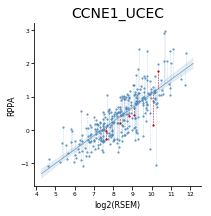

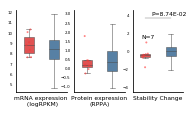

In [7]:
protein = "CYCLINE1"
cancer = "UCEC"
query_data,query_data_wt,query_data_mt=get_data(protein,cancer)
plot_regression(query_data,query_data_wt,query_data_mt,name="CCNE1_UCEC")
plot_boxplots(query_data,query_data_wt,query_data_mt,name="CCNE1_UCEC")

In [12]:
print (query_data_mt.shape,query_data_wt.shape)

(7, 24) (286, 24)


### TP53-COADREAD

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use 

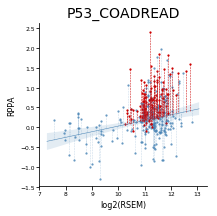

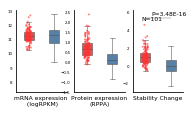

In [8]:
protein = "P53"
cancer = "COADREAD"
query_data,query_data_wt,query_data_mt=get_data(protein,cancer)
plot_regression(query_data,query_data_wt,query_data_mt,name="P53_COADREAD")
plot_boxplots(query_data,query_data_wt,query_data_mt,name="P53_COADREAD")

In [14]:
print (query_data_mt.shape,query_data_wt.shape)

(101, 24) (215, 24)


### CHECK1-UCEC

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use 

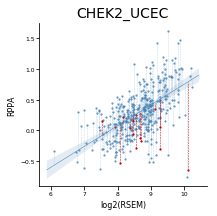

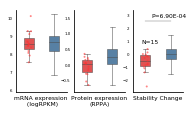

In [9]:
protein = "CHK2"
cancer = "UCEC"
query_data,query_data_wt,query_data_mt=get_data(protein,cancer)
plot_regression(query_data,query_data_wt,query_data_mt,name="CHEK2_UCEC")
plot_boxplots(query_data,query_data_wt,query_data_mt,name="CHEK2_UCEC")

In [17]:
print (query_data_mt.shape,query_data_wt.shape)

(15, 24) (356, 24)
